In [23]:
from lib.main_func_p1 import path, timer
import pandas as pd
from importlib import reload
from collections import OrderedDict
import lib.main_func_p4
from lib.main_func_p4 import modelXGBoost_fit_scores


#XGBoost library
import xgboost as xgb


In [24]:
# proteina (uniprot_ID)
uniprot_id = 'P56817'
excel_name = 'P56817_20220603102130_top_scores_XGBClassifier_balanced_accuracy_rf4'
path_file = path(uniprot_id)
# Parametros
seed = 142857
fp_name = 'morgan2_c'

In [25]:
# Load top_scores
top_scores = pd.read_excel(f'./top_scores/{excel_name}.xlsx')

# Best calibration scores
top_socres_len = 15
top_scores_top = top_scores.iloc[:top_socres_len]
top_scores_top_index_list = top_scores_top.index
top_scores

,model,params_dict,AUC_train,AUC_valid,accuracy_train,accuracy_valid,recall_train,recall_valid,specificity_train,specificity_valid,precision_train,precision_valid,f1_score_train,f1_score_valid,conf_matrix_train,conf_matrix_valid,calibration_score
0,modelID_340,"OrderedDict([('alpha', 0.1), ('gamma', 0.0), (...",0.996,0.961,0.988,0.944,0.998,0.985,0.927,0.693,0.988,0.951,0.987,0.941,"[[629, 50], [10, 4158]]","[[83, 37], [11, 725]]",0.010314
1,modelID_425,"OrderedDict([('alpha', 0.1), ('gamma', 0.0), (...",0.995,0.952,0.987,0.939,0.996,0.982,0.932,0.675,0.988,0.949,0.986,0.936,"[[630, 49], [16, 4152]]","[[81, 39], [13, 723]]",0.010745
2,modelID_288,"OrderedDict([('alpha', 0.2), ('gamma', 0.0), (...",0.996,0.963,0.986,0.943,0.996,0.982,0.925,0.704,0.988,0.953,0.985,0.940,"[[627, 52], [18, 4150]]","[[84, 36], [13, 723]]",0.011539
3,modelID_314,"OrderedDict([('alpha', 0.3), ('gamma', 0.0), (...",0.996,0.960,0.986,0.944,0.997,0.985,0.918,0.693,0.987,0.951,0.986,0.941,"[[625, 54], [14, 4154]]","[[83, 37], [11, 725]]",0.011754
4,modelID_235,"OrderedDict([('alpha', 0.1), ('gamma', 0.1), (...",0.996,0.956,0.986,0.943,0.996,0.984,0.925,0.692,0.988,0.951,0.986,0.940,"[[627, 52], [17, 4151]]","[[83, 37], [12, 724]]",0.011759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,modelID_118,"OrderedDict([('alpha', 0.1), ('gamma', 0.0), (...",0.977,0.940,0.955,0.933,0.989,0.981,0.746,0.639,0.960,0.944,0.953,0.929,"[[507, 172], [45, 4123]]","[[77, 43], [14, 722]]",0.041332
496,modelID_308,"OrderedDict([('alpha', 0.0), ('gamma', 0.2), (...",0.973,0.938,0.952,0.942,0.990,0.986,0.719,0.672,0.956,0.948,0.950,0.938,"[[490, 189], [42, 4126]]","[[80, 40], [10, 726]]",0.041597
497,modelID_12,"OrderedDict([('alpha', 0.1), ('gamma', 1.5), (...",0.972,0.939,0.934,0.911,0.999,0.996,0.535,0.390,0.929,0.909,0.925,0.895,"[[361, 318], [4, 4164]]","[[47, 73], [3, 733]]",0.049567
498,modelID_0,"OrderedDict([('alpha', 0.3), ('gamma', 0.7), (...",0.977,0.948,0.932,0.904,0.999,0.997,0.521,0.334,0.927,0.902,0.923,0.884,"[[352, 327], [3, 4165]]","[[40, 80], [2, 734]]",0.051390


In [26]:
reload(lib.main_func_p4)
from lib.main_func_p4 import modelXGBoost_fit_scores
# Load train and validation datasets
df_train = pd.read_pickle(f'{path_file}_dataset_train')
df_valid = pd.read_pickle(f'{path_file}_dataset_valid')

new_row_list = list()
results_ROF_list_train = list()
results_ROF_list_valid = list()
df_list = list()
plots_name_list = list()

for i, params_dict in enumerate(top_scores.params_dict.iloc[0:top_socres_len]):
    eval_metric = ['error', 'auc']
    tick = timer()
    params_dict_Orderer = params_dict
    params_dict = dict(eval(params_dict))
    default_params_xgb = {'booster': 'gbtree', 'tree_method': 'gpu_hist',
                          'objective':'binary:logistic', 'grow_policy': 'depthwise',
                          'eval_metric': eval_metric, 'early_stopping_rounds':10}
    params_dict.update(default_params_xgb)


    xgb_clf = xgb.XGBClassifier(**params_dict)

    # Train model and evaluating scores (train / validation)
    xgb_clf, scores_train, scores_valid = modelXGBoost_fit_scores(xgb_clf, fp_name, df_train, df_valid,
                                                                  resample_factor=4,
                                                                  resample_mode='under_sampling')

    if i == 0:
        xgb_clf.save_model(f'./models/{uniprot_id}_model.ubj')
        print(f'Best model saved ({top_scores.model.iloc[i]})')

    # ROF results
    results_ROF_list_train.append(scores_train[7])
    results_ROF_list_valid.append(scores_valid[7])

    # save pred and pred_prob of train set
    df = df_train[['activity', 'prediction', 'prediction_prob']].copy()
    df_list.append(df)

    plots_name_list.append(top_scores.model.iloc[i])
    print(f'{i+1}/{top_socres_len}. {top_scores.model.iloc[i]}. AUC_socre=(train={scores_train[0]},'
          f' valid={scores_valid[0]}). Time elapsed: {timer(tick)}')

under_sampling - 4: 4847 to 3395
Best model saved (modelID_340)
1/15. modelID_340. AUC_socre=(train=0.992, valid=0.954). Time elapsed: 3.4 seconds.
under_sampling - 4: 4847 to 3395
2/15. modelID_425. AUC_socre=(train=0.99, valid=0.949). Time elapsed: 3.5 seconds.
under_sampling - 4: 4847 to 3395
3/15. modelID_288. AUC_socre=(train=0.993, valid=0.956). Time elapsed: 4.2 seconds.
under_sampling - 4: 4847 to 3395
4/15. modelID_314. AUC_socre=(train=0.993, valid=0.952). Time elapsed: 3.6 seconds.
under_sampling - 4: 4847 to 3395
5/15. modelID_235. AUC_socre=(train=0.989, valid=0.944). Time elapsed: 3.4 seconds.
under_sampling - 4: 4847 to 3395
6/15. modelID_459. AUC_socre=(train=0.986, valid=0.951). Time elapsed: 3.2 seconds.
under_sampling - 4: 4847 to 3395
7/15. modelID_477. AUC_socre=(train=0.991, valid=0.956). Time elapsed: 3.4 seconds.
under_sampling - 4: 4847 to 3395
8/15. modelID_331. AUC_socre=(train=0.99, valid=0.952). Time elapsed: 3.4 seconds.
under_sampling - 4: 4847 to 3395
9/

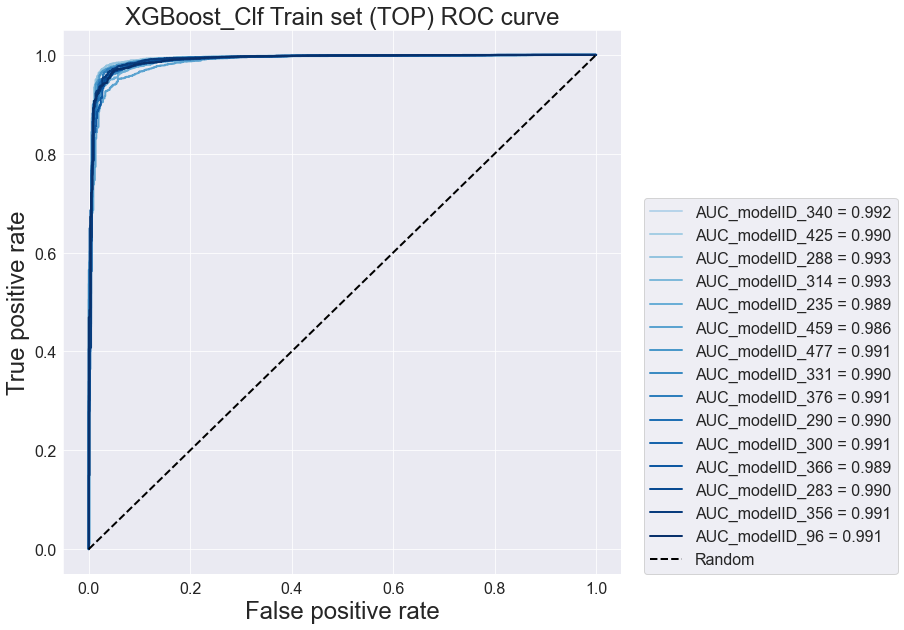

In [27]:
# ROC curve - best scores
reload(lib.main_func_p4)
from lib.main_func_p4 import plot_ROC_curve
results_ROF_train_list_top = list()
results_ROF_valid_list_top = list()
ROC_plots_name_top_name = list()
for i in top_scores_top_index_list:
    results_ROF_train_list_top.append(results_ROF_list_train[i])
    results_ROF_valid_list_top.append(results_ROF_list_valid[i])
    ROC_plots_name_top_name.append(plots_name_list[i])

model_name = f'XGBoost_Clf Train set (TOP)'
plot_ROC_curve(results_ROF_train_list_top, ROC_plots_name_top_name, model_name,
               path_file=path_file, name_mod="train_Top_score", save_fig=True)

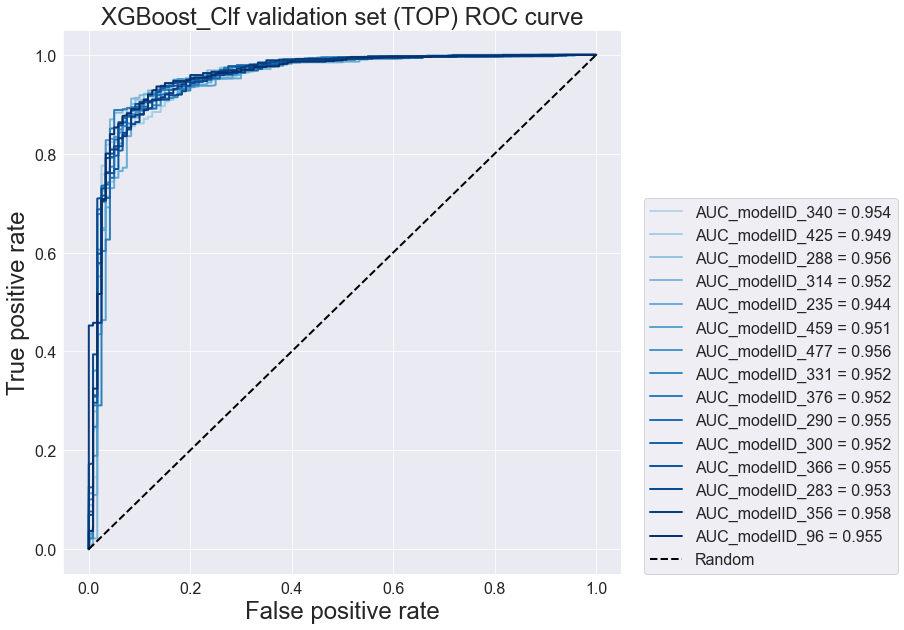

In [28]:
model_name = f'XGBoost_Clf validation set (TOP)'
plot_ROC_curve(results_ROF_valid_list_top, ROC_plots_name_top_name, model_name,
               path_file=path_file, name_mod="validation_Top_score", save_fig=True)

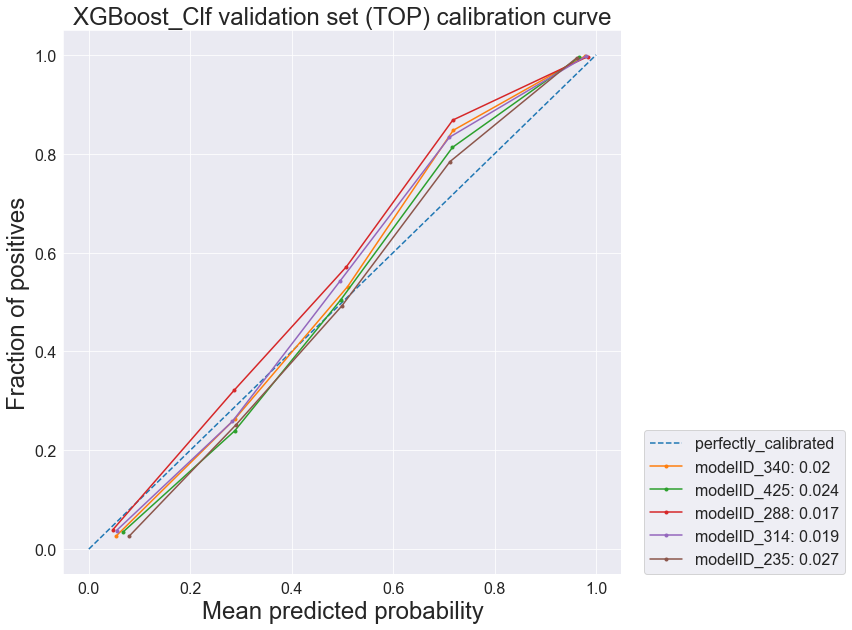

In [29]:
# Calibration curve - best scores (10)
reload(lib.main_func_p4)
from lib.main_func_p4 import plot_calibration_curve
df_list_top = list()
df_list_top_name = list()

# Only graph top 5
for i in top_scores_top_index_list:
    df_list_top.append(df_list[i])
    df_list_top_name.append((plots_name_list[i]))
plot_calibration_curve(df_list_top[:5], df_list_top_name[:5], model_name,
                       path_file=path_file, name_mod="validation_Top_score", save_fig=True)